# Learning

This example shows two ways of implementing learning in the context of NengoSPA. It
assumes some basic knowledge of learning in Nengo core, so you might want to check out
[those examples](https://www.nengo.ai/nengo/examples.html#learning) first.

In [1]:
%matplotlib inline

import nengo
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import nengo_spa as spa

seed = 0
rng = np.random.RandomState(seed + 1)

In this example, we will be learning simple associations from fruits (orange, apricot,
cherry, apple) to their colors (orange, yellow, red, green). Thus, we will set up
vocabularies accordingly and define the desired target associations.

In [2]:
dim = 64
vocab_fruits = spa.Vocabulary(dimensions=dim, pointer_gen=rng)
vocab_colors = spa.Vocabulary(dimensions=dim, pointer_gen=rng)

fruits = ["ORANGE", "APRICOT", "CHERRY", "APPLE"]
vocab_fruits.populate(";".join(fruits))

colors = ["ORANGE", "YELLOW", "RED", "GREEN"]
vocab_colors.populate(";".join(colors))

targets = {
    "ORANGE": "ORANGE",
    "APRICOT": "YELLOW",
    "CHERRY": "RED",
    "APPLE": "GREEN",
}

matplotlib_colors = {
    "ORANGE": "tab:orange",
    "YELLOW": "yellow",
    "RED": "tab:red",
    "GREEN": "tab:green",
}
matplotlib_color_cycle = cycler(
    "color", [matplotlib_colors[k] for k in vocab_colors.keys()]
)

Furthermore, we define some variables:

* length of the learning period,
* the duration each item will be shown before switching to the next one,
* and the total simulation time.

We also define some helper functions to provide the desired inputs to the model.

In [3]:
item_seconds = 0.2
learn_for_seconds = 10 * item_seconds * len(fruits)

run_for_seconds = learn_for_seconds + len(fruits) * item_seconds


def is_recall(t):
    return t > learn_for_seconds


def current_item(t):
    return fruits[int(t // item_seconds) % len(fruits)]


def current_target(t):
    return targets[current_item(t)]

## Method 1: Represent the Semantic Pointers in single, large ensembles

The `State` module in NengoSPA isn't a single ensemble, but a slightly more complex
network to ensure an accurate representation of Semantic Pointers. However, learning
connections work between individual ensembles and not whole networks. To implement
learning between two SPA `State` modules, we can configure the modules to produce only
single ensembles and connect those with a learning connection.

Two parameters are important for this:

* `subdimensions` needs to be set to the total dimensionality of the `State`'s
vocabulary,
* `represent_cc_identity` must be set to `False`.

The `State` ensemble itself can then be accessed via the `all_ensembles` property, which
will only have a single element in this case.

In [4]:
with spa.Network() as model:
    # Inputs to the model
    item = spa.Transcode(
        lambda t: vocab_fruits[current_item(t)], output_vocab=vocab_fruits
    )
    target = spa.Transcode(
        lambda t: vocab_colors[current_target(t)], output_vocab=vocab_colors
    )

    # States/ensembles for learning
    # Note that the `error` state may use multiple ensembles.
    pre_state = spa.State(
        vocab_fruits, subdimensions=vocab_fruits.dimensions, represent_cc_identity=False
    )
    post_state = spa.State(
        vocab_colors, subdimensions=vocab_colors.dimensions, represent_cc_identity=False
    )
    error = spa.State(vocab_colors)

    # Setup the item input and error signals
    item >> pre_state
    -post_state >> error
    target >> error

    # Create the learning connection with some randomly initialized weights
    assert len(pre_state.all_ensembles) == 1
    assert len(post_state.all_ensembles) == 1
    learning_connection = nengo.Connection(
        pre_state.all_ensembles[0],
        post_state.all_ensembles[0],
        function=lambda x: np.random.random(vocab_colors.dimensions),
        learning_rule_type=nengo.PES(0.00015),
    )
    nengo.Connection(error.output, learning_connection.learning_rule, transform=-1)

    # Suppress learning in the final iteration to test recall
    is_recall_node = nengo.Node(is_recall)
    for ens in error.all_ensembles:
        nengo.Connection(
            is_recall_node, ens.neurons, transform=-100 * np.ones((ens.n_neurons, 1))
        )

    # Probes to record simulation data
    p_target = nengo.Probe(target.output)
    p_error = nengo.Probe(error.output, synapse=0.01)
    p_post_state = nengo.Probe(post_state.output, synapse=0.01)

In [5]:
with nengo.Simulator(model) as sim:
    sim.run(run_for_seconds)

As a sanity check we can look at the norm of the error and see it decrease.

Text(0, 0.5, 'Error norm')

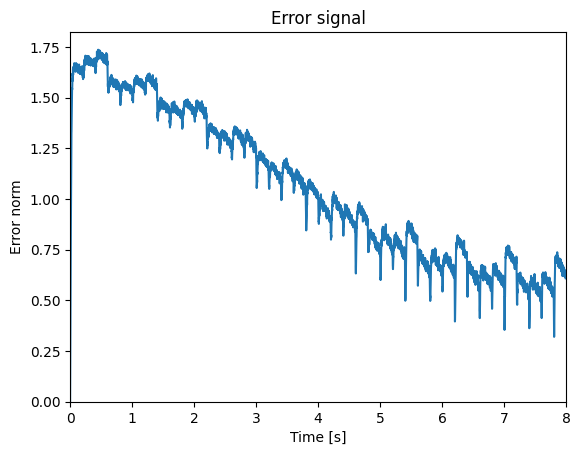

In [6]:
plt.figure()
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_error], axis=1))
plt.xlim(0, learn_for_seconds)
plt.ylim(bottom=0)
plt.title("Error signal")
plt.xlabel("Time [s]")
plt.ylabel("Error norm")

And here is the recall of the learned associations compared to the target colors:

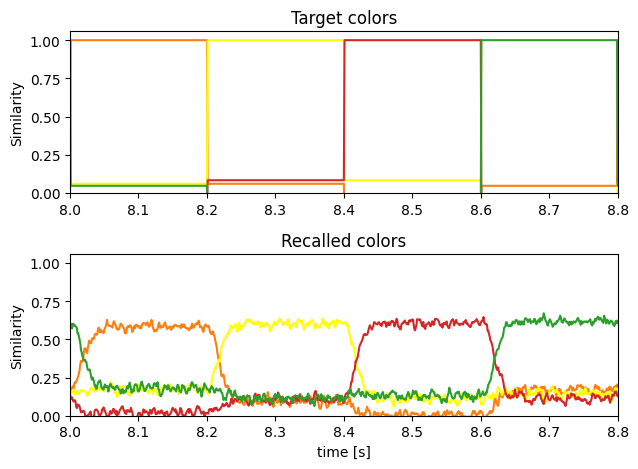

In [7]:
plt.figure()
ax = plt.subplot(2, 1, 1)
ax.set_prop_cycle(matplotlib_color_cycle)
plt.plot(sim.trange(), spa.similarity(sim.data[p_target], vocab_colors))
plt.ylim(bottom=0)
plt.title("Target colors")
plt.ylabel("Similarity")

ax = plt.subplot(2, 1, 2, sharex=ax, sharey=ax)
ax.set_prop_cycle(matplotlib_color_cycle)
plt.plot(sim.trange(), spa.similarity(sim.data[p_post_state], vocab_colors))
plt.xlim(learn_for_seconds, run_for_seconds)
plt.title("Recalled colors")
plt.xlabel("time [s]")
plt.ylabel("Similarity")
plt.tight_layout()

### Considerations

This approach allows for full connectivity between the two `State` modules. Thus, any
linear transform could be learned in theory.

However, single ensembles representing large dimensionalities need much more neurons to
achieve the same representational accuracy compared to multiple ensembles, where each
only represents a subset of all dimensions. Additionally, the model build time and
memory usage can be a problem with such large ensembles.

## Method 2: Create multiple, pairwise connections between the state ensembles

Instead of configuring the `State` modules to use only a single ensemble, we can use the
default configuration with multiple ensembles and create a separate connection between
each pair of ensembles in the pre-synaptic and post-synaptic `State`. This can be done
with a simple `for` loop and using `zip` to create the appropriate ensemble pairs. In
addition, we need to connect the error signal analogously.

In [8]:
with spa.Network() as model:
    # Inputs to the model
    item = spa.Transcode(
        lambda t: vocab_fruits[current_item(t)], output_vocab=vocab_fruits
    )
    target = spa.Transcode(
        lambda t: vocab_colors[current_target(t)], output_vocab=vocab_colors
    )

    # States/ensembles for learning
    pre_state = spa.State(vocab_fruits)
    post_state = spa.State(vocab_colors)
    error = spa.State(vocab_colors)

    # Setup the item input and error signals
    item >> pre_state
    -post_state >> error
    target >> error

    # Create pairwise learning connections with randomly initialized weights
    for pre_ensemble, post_ensemble, error_ensemble in zip(
        pre_state.all_ensembles, post_state.all_ensembles, error.all_ensembles
    ):
        learning_connection = nengo.Connection(
            pre_ensemble,
            post_ensemble,
            function=lambda x, post_ensemble=post_ensemble: np.random.random(
                post_ensemble.dimensions
            ),
            learning_rule_type=nengo.PES(0.00015),
        )
        nengo.Connection(
            error_ensemble, learning_connection.learning_rule, transform=-1
        )

    # Suppress learning in the final iteration to test recall
    is_recall_node = nengo.Node(is_recall)
    for ens in error.all_ensembles:
        nengo.Connection(
            is_recall_node, ens.neurons, transform=-100 * np.ones((ens.n_neurons, 1))
        )

    # Probes to record simulation data
    p_target = nengo.Probe(target.output)
    p_error = nengo.Probe(error.output, synapse=0.01)
    p_post_state = nengo.Probe(post_state.output, synapse=0.01)

In [9]:
with nengo.Simulator(
    model,
) as sim:
    sim.run(run_for_seconds)

We can look at the error signal again as a sanity check:

Text(0, 0.5, 'Error norm')

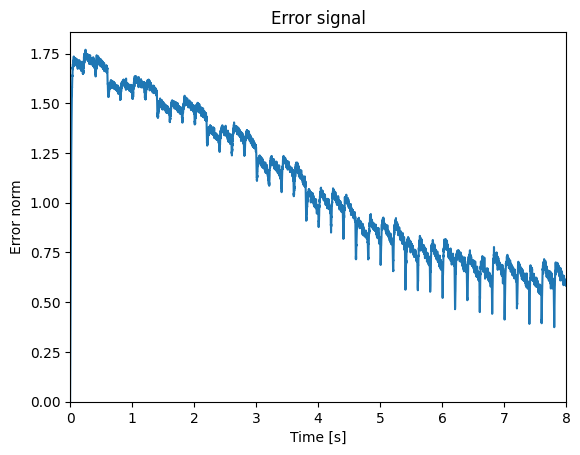

In [10]:
plt.figure()
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_error], axis=1))
plt.xlim(0, learn_for_seconds)
plt.ylim(bottom=0)
plt.title("Error signal")
plt.xlabel("Time [s]")
plt.ylabel("Error norm")

The recall of the learned associations:

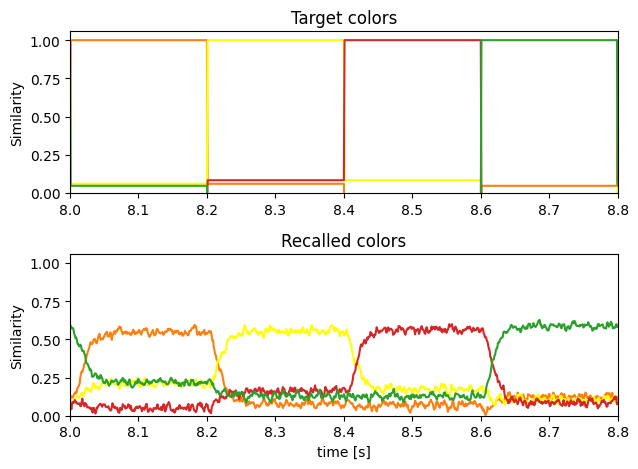

In [11]:
plt.figure()
ax = plt.subplot(2, 1, 1)
ax.set_prop_cycle(matplotlib_color_cycle)
plt.plot(sim.trange(), spa.similarity(sim.data[p_target], vocab_colors))
plt.ylim(bottom=0)
plt.title("Target colors")
plt.ylabel("Similarity")

ax = plt.subplot(2, 1, 2, sharex=ax, sharey=ax)
ax.set_prop_cycle(matplotlib_color_cycle)
plt.plot(sim.trange(), spa.similarity(sim.data[p_post_state], vocab_colors))
plt.xlim(learn_for_seconds, run_for_seconds)
plt.title("Recalled colors")
plt.xlabel("time [s]")
plt.ylabel("Similarity")
plt.tight_layout()

### Considerations

By using the default ensemble configuration, this approach scales better with regards to
build time and representational accuracy. However, the space of potentially learnable
functions is limited. Only connectivity matrices with a block diagonal structure can be
learned. It is not possible to learn a connection from the $n$-th pre-ensemble to the
$m$-th post-ensemble for $n \neq m$. This can be fine for certain use cases, such as
learning associations, but might not be fine for other use cases. For example, learning
the involution is probably not possible with this approach as it requires reversing most
of the vector.